In [ ]:
#@title Install prerequisite, this will take a while
# Install prerequisite, no need to run this if you are running the notebook from
# your laptop and you already install the packages in Anaconda 

!pip install biopython
!pip install ipytree
!pip install scikit-allel
!pip install zarr

# install mafft commandline
!wget https://mafft.cbrc.jp/alignment/software/mafft_7.471-1_amd64.deb
!sudo dpkg -i mafft_7.471-1_amd64.deb
#!wget https://mafft.cbrc.jp/alignment/software/mafft-7.471-linux.tgz
#!tar -zxvf mafft-7.471-linux.tgz
#!ln -s $(pwd)/mafft-linux64/mafftdir/bin/mafft /bin/mafft

     |████████████████████████████████| 2.3MB 5.8MB/s 
     |████████████████████████████████| 1.3MB 5.7MB/s 
     |████████████████████████████████| 10.8MB 5.9MB/s 
  Created wheel for scikit-allel: filename=scikit_allel-1.3.3-cp37-cp37m-linux_x86_64.whl size=4696002 sha256=2e1fffecaf7064573ddd0fa22bbc3f06dde10f503be72745ecaffdf8c1d16c32
  Stored in directory: /root/.cache/pip/wheels/a7/2d/dc/a1ef6b48b94aa072114bbb8c81de4393adef3b595679aaa910
Successfully built scikit-allel
     |████████████████████████████████| 143kB 4.3MB/s 
     |████████████████████████████████| 5.8MB 20.8MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-cp37-none-any.whl size=5037 sha256=ca13fa3ac92c6beec3d2d4bf47134c55a1319a4eea518dbd8737f3fac86b3e18
  Stored in directory: /root/.cache/pip/wheels/1d/d9/58/9808b306744df0208fccc640d3d9952a5bc7468502d42897d5
Successfully built asciitree
--2021-04-26 03:14:00--  https://mafft.cbrc.jp/alignment/software/mafft_7.471-1_amd64.deb
Resolving mafft.cbrc.jp (ma

In [ ]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
# Set up data folder
from pathlib import Path

# Change this to where you put your hw1 files
DATA = Path("/content/drive/My Drive/2020 ECBM E4060/data/hw1")

# Columbia: Genomics Assignment 1 - Sequence Alignment and Data Analysis

## SARS-CoV-2 Genome Multiple Alignment




Severe acute respiratory syndrome coronavirus 2, or SARS-CoV-2, is responsible for the COVID-19 pandemic. The outbreak of the COVID-19 has brought together the global genomic research community to focus on understanding the virus at an unprecedent speed. As of September 2020, there has been more than 52,000 sequence runs, and 23,000 nucleotide records published on the National Center for Biotechnology Information (NCBI) website (https://www.ncbi.nlm.nih.gov/sars-cov-2/). In this homework, we will utilize the genomic sequences of SARS-CoV-2 submitted from different global location to see how the virus mutated into novel strands when it spreads across the world.

There has been many researches focusing on this topic. Here we will do an ultra-simplified version of the analysis done in [_Dorp et al._](https://www.sciencedirect.com/science/article/pii/S1567134820301829) paper published in Sept. 2020. 


### Fetch virus genomic sequences from GenBank

You can find all the SARS-CoV-2 genome metadata available in a tabular format [here](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=SARS-CoV-2,%20taxid:2697049). In order to process it more efficiently, I have downloaded the full table in a flat file in our shared google drive:

[sars_cov_2_sequence_manifest.csv](https://drive.google.com/file/d/1dN3OMbIj67Kq6nZvs7UJOoeY7X8xJ56m/view?usp=sharing)

You can load the manifest table through the following code:

In [ ]:
import pandas as pd

manifest = pd.read_csv(DATA / "sars_cov_2_sequence_manifest.csv",
                       parse_dates=["Collection_Date"])

# like in Dorp et al. paper, we will only include `complete` sequences
manifest = manifest[manifest.Nuc_Completeness == "complete"]

manifest.head()

,Accession,SRA_Accession,Release_Date,Species,Genus,Family,Length,Sequence_Type,Nuc_Completeness,Genotype,Segment,Authors,Publications,Geo_Location,U.S._State,Host,Isolation_Source,Collection_Date,BioSample,GenBank_Title
0,NC_045512,NaN,2020-01-13T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,29903,RefSeq,complete,NaN,NaN,"Wu,F., Zhao,S., Yu,B., Chen,Y.M., Wang,W., Son...","32015508, 15680415, 15630477, 10482585",China,NaN,Homo sapiens,NaN,2019-12-01,NaN,Severe acute respiratory syndrome coronavirus ...
1,MT990449,NaN,2020-09-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,29787,GenBank,complete,NaN,NaN,"Soliman,M.S., Abdelfattah,M., Aziz,R.K.",NaN,Egypt: Cairo,NaN,Homo sapiens,oronasopharynx,2020-05-19,NaN,Severe acute respiratory syndrome coronavirus ...
2,MT990450,NaN,2020-09-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,29792,GenBank,complete,NaN,NaN,"Soliman,M.S., Abdelfattah,M., Aziz,R.K.",NaN,Egypt: Cairo,NaN,Homo sapiens,oronasopharynx,2020-06-19,NaN,Severe acute respiratory syndrome coronavirus ...
3,MT981086,NaN,2020-09-08T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,29868,GenBank,complete,NaN,NaN,"Fink,L.",NaN,USA: Virginia,VA,Homo sapiens,NaN,2020-07-01,NaN,Severe acute respiratory syndrome coronavirus ...
4,MT981087,NaN,2020-09-08T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,29864,GenBank,complete,NaN,NaN,"Fink,L.",NaN,USA: Virginia,VA,Homo sapiens,NaN,2020-07-01,NaN,Severe acute respiratory syndrome coronavirus ...


There are too many sequences to analyze. We'll just take samples of the major geological areas listed below to perform the multiple alignment. We selected the regions based on the top COVID-19 cases here: https://www.statista.com/statistics/1043366/novel-coronavirus-2019ncov-cases-worldwide-by-country/

Note some of the high-prevalence locations were not included due to the limitation of sequence availability in NCBI.

In [ ]:
geo_location_of_interest = {
    "USA: NY", "USA: CA", "USA: TX", # N America
    "Brazil", "Chile", "Mexico: Tijuana, BajaCalifornia", # C/S America
    "France", "Spain", "Italy", # W/C/S Europe
    "Egypt", "Morocco", # Africa
    "Iran", "Bangladesh", "Saudi Arabia", # W/S Asia
    "Philippines: NCR, Quezon City", "Japan", "Taiwan", # E Asia
    "India: Ahmedabad", "India: Vadodara", "India: Surat", # India
    "China", "China: Beijing", "China: Wuhan", # China
}

For each geo-location, we'll take the latest 3 sequences from the location. We can do this by sorting the manifest DataFrame by the `Collection_Date` column:

In [ ]:
seq_of_interest = manifest[
    manifest.Geo_Location.isin(geo_location_of_interest)
].groupby("Geo_Location").apply(
    lambda df: df.sort_values("Collection_Date").iloc[:3]
).reset_index(drop=True)

# You should have 3 sequences at each location if you run:
seq_of_interest.groupby("Geo_Location").Accession.nunique()

Geo_Location
Bangladesh                         3
Brazil                             3
Chile                              3
China                              3
China: Beijing                     3
China: Wuhan                       3
Egypt                              3
France                             3
India: Ahmedabad                   3
India: Surat                       3
India: Vadodara                    3
Iran                               3
Italy                              3
Mexico: Tijuana, BajaCalifornia    3
Morocco                            3
Philippines: NCR, Quezon City      3
Saudi Arabia                       3
Spain                              3
Taiwan                             3
USA: CA                            3
USA: NY                            3
USA: TX                            3
Name: Accession, dtype: int64

### Multiple alignment and construct a phylogenetic tree

With the accession IDs in the `seq_of_interest` DataFrame, you should be able to fetch the genomic sequences. 

In [ ]:
from Bio import Entrez
from Bio import SeqIO

# Set your email address for genbank query
Entrez.email = "michael.y@columbia.edu"

#=============================================================================
# Fetch genomic sequences from seq_of_interest. You can make one query of all
# the sequences by concatenate the IDs with commas 
# Once you fetched the sequences from genbank, you should save them in a fasta
# file in order to run multiple sequence alignment afterwards
seq_ids = ",".join(seq_of_interest.Accession)
sequences = Entrez.efetch(db="nucleotide", id=seq_ids, rettype="fasta")

fasta_file = "accession_ids.fasta"
with open(fasta_file, "w") as fo:
    fo.write(sequences.read())

#=============================================================================

Now we have the sequences, let's run multiple sequence alignment. Following the footsteps of the [_Dorp et al._](https://www.sciencedirect.com/science/article/pii/S1567134820301829), we'll use [MAFFT](https://biopython.org/docs/1.75/api/Bio.Align.Applications.html#Bio.Align.Applications.MafftCommandline) alignment algorithm. Similar to other multiple alignment algorithms, there is a `biopython` commandline wrapper for us to run easily: `MafftCommandline` under `Bio.Align.Applications`. Refer to the [documentation in biopython](https://biopython.org/docs/1.75/api/Bio.Align.Applications.html#Bio.Align.Applications.MafftCommandline). Perform multiple sequence alignment on the fasta file you just wrote.

In [ ]:
#============================================================================
# Perform multiple sequence alignment using MafftCommandline class and write
# the alignment result to another fasta file
from Bio.Align.Applications import MafftCommandline

input = "accession_ids.fasta"
mafft_cline = MafftCommandline(input = input)
print(mafft_cline)

stdout, stderr = mafft_cline()
with open("accession_ids.fasta", "w") as handle:
    handle.write(stdout)
from Bio import AlignIO
align = AlignIO.read("accession_ids.fasta", "fasta")

print(align)

#============================================================================

mafft accession_ids.fasta
Alignment with 66 rows and 29919 columns
-ttaaaggtttataccttcccaggtaacaaaccaaccaactttc...--- MT476385.1
--------------------------------caaccaactttc...--- MT577359.1
-------------------------aacaaaccaaccaactttc...--- MT566435.1
attaaaggtttataccttcccaggtaacaaaccaaccaactttc...--- MT126808.1
attaaaggtttataccttcccaggtaacaaaccaaccaactttc...--- MT738101.1
attaaaggtttataccttcccaggtaacaaaccaaccaactttc...--- MT350282.1
--------------------------------------------...--- MT670015.1
--------------------------------------------...--- MT670013.1
--------------------------------------------...--- MT670014.1
attaaaggtttataccttcccaggtaacaaaccaaccaactttc...--- NC_045512.2
attaaaggtttataccttcccaggtaacaaaccaaccaactttc...--- MN908947.3
-ttaaaggtttataccttcccaggtaacaaaccaaccaactttc...--- MN988669.1
-----------ataccttcccaggtaacaaaccaaccaactttc...act MT034054.1
-----aggtttataccttcccaggtaacaaaccaaccaactttc...--- MT291831.1
--------tttataccttcccaggtaacaaaccaaccaactttc...--- MT291832.1
--

With the alignment done, we can construct a [phylogenetic tree](https://en.wikipedia.org/wiki/Phylogenetic_tree) to quantify and visualize the genomic evolution of the virus taken from different locations. You can follow the document of [biopython's Phylo module](https://biopython.org/wiki/Phylo). Here we will build the phylogenetic tree using the [UPGMA](https://en.wikipedia.org/wiki/UPGMA) method, which can be called through the [DistanceTreeConstructor](https://biopython.org/docs/1.75/api/Bio.Phylo.TreeConstruction.html#Bio.Phylo.TreeConstruction.DistanceTreeConstructor) class.


In [ ]:
#====================================================================
# Build a phylogenetic tree using the MAFFT multiple alignment result
# Remember to visualize your tree using the Bio.Phylo.draw function
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator

calculator = DistanceCalculator('identity')
dm = calculator.get_distance(align)
# print(dm)
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)
print(tree)

# constructor = DistanceTreeConstructor(calculator, 'upgma')
# tree = constructor.build_tree(align)
# print(tree)

#====================================================================


Tree(rooted=True)
    Clade(branch_length=0, name='Inner65')
        Clade(branch_length=0.012389325558483821, name='MT374101.1')
        Clade(branch_length=0.007791875211100594, name='Inner64')
            Clade(branch_length=0.008445788961413282, name='Inner16')
                Clade(branch_length=4.177947123901182e-05, name='Inner8')
                    Clade(branch_length=5.013536548681419e-05, name='MT810783.1')
                    Clade(branch_length=5.013536548681419e-05, name='MT810784.1')
                Clade(branch_length=9.191483672582601e-05, name='MT810786.1')
            Clade(branch_length=0.00394025345075588, name='Inner63')
                Clade(branch_length=0.0045974503473832275, name='MT451877.1')
                Clade(branch_length=0.002418736602825013, name='Inner62')
                    Clade(branch_length=0.00018401596809860697, name='Inner61')
                        Clade(branch_length=0.0021787137445582147, name='MT451874.1')
                        Clade(b

In [ ]:
location = manifest.loc[manifest['Accession'] == 'MN908947']
location['Geo_Location']

22984    China
Name: Geo_Location, dtype: object

#### **1.2. From the phylogenetic tree you created, there should be one virus sequence with much larger distance from all the others. What is the sequence ID of that virus? Where is its geo location? You may look at the visualization of the tree, or directly read into the tree by `print(tree)`**

The virus sequence with the largest distance is MT374101.1, with a GEO location in Taiwan.


In [ ]:
location = manifest.loc[manifest['Accession'] == 'MT374101']
location['Geo_Location']

21480    Taiwan
Name: Geo_Location, dtype: object

#### **1.3. The sequence `NC_045512.2` is the RefSeq sequence of the SARS-CoV-2, which means it is the "reference genome" used as a canonical sequence for all the future study. It was first submitted from Wuhan, China. Find in your phylogenetic tree what is the sequence that's closest to `NC_045512.2`, and what is its geo location?**

The sequence closest to NC_045512.2 is MN908947.3, in China.


### Identify mutations in spike glycoprotein region

The spike glycoprotein (gene name `S`) is a critical protein for the coronavirus. Not only it forms the external structure (hence giving it the name "corona"), it also allows the virus to bind to specific receptors on the surface of a human cell (namely the `ACE2` gene, which we will talk about during the class), the first step toward infecting the cell. Therefore, it has been a hot target for [vaccine development](https://www.nature.com/articles/s41586-020-2599-8) as well.

To further dig into our multiple alignment result, let's take a look at the most distinct coronavirus strand in our collection. Use the multiple alignment result, identify in which positions in the `S` protein does the most distinct coronavarus have mutations compared with the reference sequence `NC_045512.2`.

Note the `S` protein ranges from [`21563..25384`](https://www.ncbi.nlm.nih.gov/nuccore/NC_045512) in the SARS-CoV-2 reference genome.

In [ ]:
#====================================================================
# Write your code here
# Load the alignment result fasta file, identify in which positions in S
# protein does the coronavirus strand in question 1.2 have mutations when
# compared with the reference genome NC_045512.2
import pandas as pd

# Reading alignment file again
aln = AlignIO.read(open(input), 'fasta')
# align_df = pd.DataFrame(aln)
#====================================================================

In [ ]:
refseq_id = 9
seq_id = 56
#After settling the IDs of the reference and the 1.2 sequence, we can start to iterate through

refseq_total = aln[refseq_id].seq
resseq_total = aln[seq_id].seq

# Find the values of the nucleotide at the location
ref_seq = str(refseq_total[21563:25384])
res_seq = str(resseq_total[21563:25384])

range_front = 21563

# Find the position relative to the section given for the mutation
l = len(ref_seq)
for i in range(l):
  if ref_seq[i] != res_seq[i]:
    i = i + range_front
    print(i)

print(ref_seq[index])
print(res_seq[index])

# From this, we can assume that whenever the reference sequence has a C, the result sequence has a T.
# These will be at positions 144 and 2650 along the section 21563-25384, specifically at positions 21707 and 24213.

21707
24213
c
t


#### **1.4. In which positions does the coronavirus strand in question 1.2 have mutations compared with `NC_045512.2`? What are the nucleotide changes? Try to use the HGVS format to describe the mutations (_e.g._ `c.22313A>C`) ?**

As shown, there are two mutations that occur within the section given between NC_045512.2 and the coronavirus strand from 1.2, in the form of changes from C > T.

NC_045512.2: c.21707C>T

NC_045512.2: c.24213C>T

## Data Analysis: COVID-19andMe

Having information regarding the genetic variants of a person not only allows us to trace one's geneology and ancestry, it also helps conduct studies for better understanding of how people with different genetic composition respond to diseases. [Genome-wide association study](https://en.wikipedia.org/wiki/Genome-wide_association_study), or GWAS, identifies associations between genetic variants and various "traits". These traits range from trivial biological features such as height, weight, eye colors, to more clinical outcomes such as disease severity or drug sensitivity. 

Consumer genetic testing companies like 23andMe or Ancestry take advantage of the outcome of such studies. When you purchase their genetic testing product, not only you receive the variants of your genome, they also provide a report highlighting the genetic variants that have been reported in the literature to be associated with disease, drug efficacy, or adverse effect. Releasing such information to general consumers who have no prior knowledge about how such information was generated or what these association mean could in fact cause more harm than good, as mentioned in [this article](https://knowledge.wharton.upenn.edu/article/fda-vs-23andme-lesson-health-care-entrepreneurs/). 

In this exercise, we will try to generate such genetic testing report, with a focus on the severity of COVID-19, using the variants from subjects from the 1000 genome project. Since the beginning of 2020, there have been many studies trying to understand what causes the wide symptom range of COVID-19. Many GWAS or [case-parent trio](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4139708/) studies have been conducted to understand associations between different genetic variants and COVID-19 prognosis. The variants in gene `ACE2`, which is the cell surface receptor that the SARS-CoV-2 spike protein binds to, will be covered in the class. Here we will combine the variants in ACE2 we used in the class with another COVID-19 severity-related variants in the same chromosome X:

* `chrX: g.12905756_12905759del` and `chrX: g.12906010G>T` reported in this familial study by [van der Made _et. al._](https://jamanetwork.com/journals/jama/fullarticle/2768926)

These two variants locate in gene `TLR7`, which is a key component in innate immune response. Damage to the gene is expected to have serious impact on immune functions. 

Now let's pretend we have a COVID-19 risk genetic testing company: there are two "customers" coming in today. They are the 1000 genome project celebrity `NA21106` and `HG02429`. They would like to know if there is any COVID-19 risk factor in their Chromosome X. Since we have their whole genome information, we will just pull out their variant data from 1000 genome project and annotate them with the variants that would cause impact on `ACE2` and `TLR7`.

You will find the VCF / VEP files of chromosome X we used in the class has also been short-cut in the `hw1` directory as well:


In [ ]:
# you can find the VCF and VEP files of chromosome X in the data/hw1 directory
vcf_filename = DATA / "ALL.chrX.phase3_shapeit2_mvncall_integrated_v1b.20130502.genotypes.vcf.gz"
vep_filename = DATA / "ALL.chrX.phase3_shapeit2_mvncall_integrated_v1b.20130502.genotypes.vep.txt.gz"

### Filter variants in VEP file to `ACE2` and `TLR7`

As a first step, similar to what we do in the class, we filter the VEP file to leave only of `MODERATE` and `HIGH` impact variants in both `ACE2` and `TLR7` genes. Remember to use only the `CANONICAL` transcript (`CANONICAL=YES`).

In [ ]:
#============================================================================
# Load and filter the VEP file to keep only MODERATE and HIGH impact variants
# in ACE2 and TLR7 gene
import gzip

def get_vcfvep_header(filename):
    with gzip.open(filename, "rb") as fi:
        for l in fi:
            l = l.decode("utf-8")
            if l.startswith("##"):
                continue
            elif l.startswith("#"):
                return l[1:].strip().split("\t")
            else:
                raise ValueError("Something wrong in the VEP file!")

vep_header = get_vcfvep_header(vep_filename)
vep_header
#============================================================================

['Uploaded_variation',
 'Location',
 'Allele',
 'Gene',
 'Feature',
 'Feature_type',
 'Consequence',
 'cDNA_position',
 'CDS_position',
 'Protein_position',
 'Amino_acids',
 'Codons',
 'Existing_variation',
 'Extra']

In [ ]:
import pandas as pd

vep = pd.read_csv(vep_filename, comment='#', sep="\t")
vep.columns = vep_header
vep.head(5)

,Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,Extra
0,X_60021_-/A/AAC,X:60020-60021,AAC,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER;VARIANT_CLASS=insertion
1,X_60026_T/C,X:60026,C,-,-,-,intergenic_variant,-,-,-,-,-,rs774535218,IMPACT=MODIFIER;VARIANT_CLASS=SNV;AF=0.0050;AF...
2,X_60032_T/C,X:60032,C,-,-,-,intergenic_variant,-,-,-,-,-,rs748268487,IMPACT=MODIFIER;VARIANT_CLASS=SNV;AF=0.0056;AF...
3,X_60035_CC/C/-,X:60035-60036,C,-,-,-,intergenic_variant,-,-,-,-,-,rs201278642,IMPACT=MODIFIER;VARIANT_CLASS=sequence_alterat...
4,X_60035_CC/C/-,X:60035-60036,-,-,-,-,intergenic_variant,-,-,-,-,-,rs201278642,IMPACT=MODIFIER;VARIANT_CLASS=sequence_alterat...


In [ ]:
vep["impact"] = vep.Extra.apply(lambda extra: dict([field.split("=") for field in extra.split(";")])["IMPACT"])
vep_mod_high = vep[(vep.impact == "MODERATE") | (vep.impact == "HIGH")]

In [ ]:
# Finding the ACE2 and TLR7 specifically
vep_mod_high_ACE2 = vep_mod_high[
    vep_mod_high.Extra.str.contains("SYMBOL=ACE2") &
    vep_mod_high.Extra.str.contains("CANONICAL=YES")
]

vep_mod_high_TLR7 = vep_mod_high[
    vep_mod_high.Extra.str.contains("SYMBOL=TLR7") &
    vep_mod_high.Extra.str.contains("CANONICAL=YES")
]

x = vep_mod_high_ACE2.shape
y = vep_mod_high_TLR7.shape

print("ACE2 variant number is", x, ". ", "TLR7 variant number is", y)

ACE2 variant number is (22, 15) .  TLR7 variant number is (17, 15)


In [ ]:
# Finding a filtered VEP file that only contains ACE2 and TLR7
vep_mod_high_both = vep_mod_high[
    (vep_mod_high.Extra.str.contains("SYMBOL=ACE2") |
    vep_mod_high.Extra.str.contains("SYMBOL=TLR7")) &
    vep_mod_high.Extra.str.contains("CANONICAL=YES")
]

vep_mod_high_both.shape

(39, 15)

### Find genotypes of variants of interest in the subjects

Next, we will load the VCF file to obtain the genotypes of all `ACE2` and `TLR7` MODERATE / HIGH impact variants in our "customers": `NA21106` and `HG02429`

In [ ]:
#===========================================================================
# Extract the GenotypeArray of subject NA21106 and HG02429, containing only
# variants within ACE2 and TLR7. Your end genotype array dimension should be
# (num_ACE2_TLR7_variants, 2, 2)
import numpy as np
import allel
import sys

vcf = allel.read_vcf(str(vcf_filename), ["samples", "variants/ID", "variants/numalt", "variants/REF"],
                     log=sys.stdout)

#============================================================================

[read_vcf] 65536 rows in 5.17s; chunk in 5.17s (12667 rows/s); X :1734128
[read_vcf] 131072 rows in 10.54s; chunk in 5.36s (12222 rows/s); X :3915040
[read_vcf] 196608 rows in 15.32s; chunk in 4.78s (13708 rows/s); X :6474138
[read_vcf] 262144 rows in 22.48s; chunk in 7.16s (9153 rows/s); X :9519142
[read_vcf] 327680 rows in 26.14s; chunk in 3.67s (17865 rows/s); X :12551848
[read_vcf] 393216 rows in 29.45s; chunk in 3.30s (19854 rows/s); X :15550284
[read_vcf] 458752 rows in 32.72s; chunk in 3.27s (20017 rows/s); X :18776831
[read_vcf] 524288 rows in 35.98s; chunk in 3.26s (20108 rows/s); X :21881750
[read_vcf] 589824 rows in 39.28s; chunk in 3.30s (19861 rows/s); X :24574486
[read_vcf] 655360 rows in 42.57s; chunk in 3.29s (19890 rows/s); X :27659891
[read_vcf] 720896 rows in 45.85s; chunk in 3.28s (19991 rows/s); X :30671296
[read_vcf] 786432 rows in 49.15s; chunk in 3.30s (19844 rows/s); X :33194562
[read_vcf] 851968 rows in 52.47s; chunk in 3.32s (19755 rows/s); X :36031556
[read_

In [ ]:
# Do the vcf to zarr
import os
import numpy as np

numalt = vcf['variants/numalt']
max_alt = np.max(numalt)

# clear the variable if it already exists to be gentle on memory
if "vcf" in dir():
    del vcf

zarr_file = "/content/" + vcf_filename.name.replace(".vcf.gz", ".zarr")
if not os.path.exists(zarr_file):
    allel.vcf_to_zarr(str(vcf_filename),
                      str(zarr_file),
                      group='X', fields='*', alt_number=max_alt,
                      log=sys.stdout, overwrite=True)

[vcf_to_zarr] 65536 rows in 13.30s; chunk in 13.30s (4925 rows/s); X :1734128
[vcf_to_zarr] 131072 rows in 26.85s; chunk in 13.54s (4839 rows/s); X :3915040
[vcf_to_zarr] 196608 rows in 39.22s; chunk in 12.38s (5295 rows/s); X :6474138
[vcf_to_zarr] 262144 rows in 51.81s; chunk in 12.59s (5204 rows/s); X :9519142
[vcf_to_zarr] 327680 rows in 64.16s; chunk in 12.34s (5308 rows/s); X :12551848
[vcf_to_zarr] 393216 rows in 76.53s; chunk in 12.37s (5297 rows/s); X :15550284
[vcf_to_zarr] 458752 rows in 88.89s; chunk in 12.36s (5303 rows/s); X :18776831
[vcf_to_zarr] 524288 rows in 101.22s; chunk in 12.33s (5314 rows/s); X :21881750
[vcf_to_zarr] 589824 rows in 113.70s; chunk in 12.48s (5252 rows/s); X :24574486
[vcf_to_zarr] 655360 rows in 126.11s; chunk in 12.41s (5281 rows/s); X :27659891
[vcf_to_zarr] 720896 rows in 138.48s; chunk in 12.37s (5296 rows/s); X :30671296
[vcf_to_zarr] 786432 rows in 150.90s; chunk in 12.42s (5274 rows/s); X :33194562
[vcf_to_zarr] 851968 rows in 163.29s; ch

In [ ]:
import zarr

zarr_file = vcf_filename.name.replace(".vcf.gz", ".zarr")
vcfzarr = zarr.open_group(zarr_file, mode="r")
vcfzarr.tree(expand=False)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='X', nodes=(Node(disabled=True, name…

In [ ]:
pos_of_interest = set(
    [int(x.split(':')[1]) for x in vep_mod_high_both.Location]
)

# Extract individual variant from vcfzarr files, taken from class notes
idx = pd.Series(vcfzarr["X/variants/POS"]).isin(pos_of_interest)
idx = idx[idx].index.values

In [ ]:
import allel
import numpy as np

customers = ['NA21106', 'HG02429']

# Similar to what was done before
customer_idx = pd.Series(vcfzarr["X/samples"]).isin(customers)
customer_idx = customer_idx[customer_idx].index.values

# Generate genotype array, like in class notes
GenoTyp_customers_both = np.array([vcfzarr["X/calldata/GT"][i]for i in idx])
GenoTyp_customers_both = allel.GenotypeArray(GenoTyp_customers_both)
GenoTyp_customers_both = GenoTyp_customers_both[:,customer_idx]
GenoTyp_customers_both

# Ensure that the shape is 39, 2, 2 as stated in the spec

<GenotypeArray shape=(39, 2, 2) dtype=int8>
1/. 0/0
0/. 0/0
0/. 0/0
...
0/. 0/0
0/. 0/0
0/. 0/0

In [ ]:
GenoTyp_customers_both.is_hom()
# 21 and 24 are Heterozygous
# MUST figure out which is top and bottom, left and right

array([[False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False, False],
       [False,  True],
       [False,  True],
       [False, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True]])

In [ ]:
vep_mod_high_both

,Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,Extra,impact
847944,rs179008,X:12903659,T,ENSG00000196664,ENST00000380659,Transcript,missense_variant,171,32,11,Q/L,cAa/cTa,"rs179008,CM084786,COSV66123795",IMPACT=MODERATE;STRAND=1;VARIANT_CLASS=SNV;SYM...,MODERATE
847945,X_12903826_A/G,X:12903826,G,ENSG00000196664,ENST00000380659,Transcript,missense_variant,338,199,67,T/A,Acc/Gcc,rs752095862,IMPACT=MODERATE;STRAND=1;VARIANT_CLASS=SNV;SYM...,MODERATE
847948,rs150313957,X:12904007,T,ENSG00000196664,ENST00000380659,Transcript,missense_variant,519,380,127,T/I,aCt/aTt,rs150313957,IMPACT=MODERATE;STRAND=1;VARIANT_CLASS=SNV;SYM...,MODERATE
847950,X_12904053_A/G,X:12904053,G,ENSG00000196664,ENST00000380659,Transcript,missense_variant,565,426,142,I/M,atA/atG,rs779884561,IMPACT=MODERATE;STRAND=1;VARIANT_CLASS=SNV;SYM...,MODERATE
847954,rs149314023,X:12904282,A,ENSG00000196664,ENST00000380659,Transcript,missense_variant,794,655,219,V/I,Gtc/Atc,"rs149314023,COSV66125342",IMPACT=MODERATE;STRAND=1;VARIANT_CLASS=SNV;SYM...,MODERATE
847955,rs55907843,X:12904292,A,ENSG00000196664,ENST00000380659,Transcript,missense_variant,804,665,222,V/D,gTt/gAt,"rs55907843,COSV99081047",IMPACT=MODERATE;STRAND=1;VARIANT_CLASS=SNV;SYM...,MODERATE
847957,X_12904463_T/C,X:12904463,C,ENSG00000196664,ENST00000380659,Transcript,missense_variant,975,836,279,L/P,cTa/cCa,rs759793723,IMPACT=MODERATE;STRAND=1;VARIANT_CLASS=SNV;SYM...,MODERATE
847964,rs190564296,X:12904871,A,ENSG00000196664,ENST00000380659,Transcript,missense_variant,1383,1244,415,S/N,aGc/aAc,rs190564296,IMPACT=MODERATE;STRAND=1;VARIANT_CLASS=SNV;SYM...,MODERATE
847965,rs5743781,X:12904970,T,ENSG00000196664,ENST00000380659,Transcript,missense_variant,1482,1343,448,A/V,gCc/gTc,rs5743781,IMPACT=MODERATE;STRAND=1;VARIANT_CLASS=SNV;SYM...,MODERATE
847970,X_12905389_A/G,X:12905389,G,ENSG00000196664,ENST00000380659,Transcript,missense_variant,1901,1762,588,M/V,Atg/Gtg,rs778897256,IMPACT=MODERATE;STRAND=1;VARIANT_CLASS=SNV;SYM...,MODERATE


In [ ]:
print(vep_mod_high_both.iloc[0, :])

Uploaded_variation                                             rs179008
Location                                                     X:12903659
Allele                                                                T
Gene                                                    ENSG00000196664
Feature                                                 ENST00000380659
Feature_type                                                 Transcript
Consequence                                            missense_variant
cDNA_position                                                       171
CDS_position                                                         32
Protein_position                                                     11
Amino_acids                                                         Q/L
Codons                                                          cAa/cTa
Existing_variation                       rs179008,CM084786,COSV66123795
Extra                 IMPACT=MODERATE;STRAND=1;VARIANT_CLASS=SNV

In [ ]:
Variants_alt = np.array(vcfzarr["X/variants/REF"])
Variants_alt[847944]

'A'

In [ ]:
customer_1 = ['NA21106']

# Similar to what was done before
customer_idx1 = pd.Series(vcfzarr["X/samples"]).isin(customer_1)
customer_idx1 = customer_idx1[customer_idx1].index.values

# Check for NA confirmation

# Generate genotype array
GenoTyp_customers_NA = np.array([vcfzarr["X/calldata/GT"][i]for i in idx])
GenoTyp_customers_NA = allel.GenotypeArray(GenoTyp_customers_NA)
GenoTyp_customers_NA = GenoTyp_customers_NA[:,customer_idx1]
GenoTyp_customers_NA #confirm that NA is on the right side of the original generated genotype

,0
0,0/0
1,0/0
2,0/0
...,...
36,0/0
37,0/0
38,0/0


In [ ]:
customer_2 = ['HG02429']
# TLR7 on top, ACE2 on bottom

# Similar to what was done before
customer_idx2 = pd.Series(vcfzarr["X/samples"]).isin(customer_2)
customer_idx2 = customer_idx2[customer_idx2].index.values

# Check for HG

# Generate genotype array
GenoTyp_customers_HG = np.array([vcfzarr["X/calldata/GT"][i]for i in idx])
GenoTyp_customers_HG = allel.GenotypeArray(GenoTyp_customers_HG)
GenoTyp_customers_HG = GenoTyp_customers_HG[:,customer_idx2] #confirm that HG is on the left side of the original genotype array

In [ ]:
import sys

np.set_printoptions(threshold=np.inf)
print(GenoTyp_customers_HG)

#hemizygous

1/.
0/.
0/.
...
0/.
0/.
0/.



In [ ]:
GenoTyp_customers_HG.count_alleles()
GenoTyp_customers_HG.tolist()

# Look for the hemizygous that says 1. (1 + 19)

[[[1, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[1, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]],
 [[0, -1]]]

In [ ]:
print(vep_mod_high_both.iloc[21, :])

Uploaded_variation                                          rs200180615
Location                                                     X:15584488
Allele                                                                T
Gene                                                    ENSG00000130234
Feature                                                 ENST00000427411
Feature_type                                                 Transcript
Consequence                                            missense_variant
cDNA_position                                                      2219
CDS_position                                                       2002
Protein_position                                                    668
Amino_acids                                                         E/K
Codons                                                          Gag/Aag
Existing_variation                                          rs200180615
Extra                 IMPACT=MODERATE;STRAND=-1;VARIANT_CLASS=SN

In [ ]:
Variants_alt = np.array(vcfzarr["X/variants/REF"])
Variants_alt[1001407]

'G'

To generate the report, you should report each variant that's not homozygous reference (_i.e_ `0|0`). Showing the variant ID by the format `gene_name`: `chrX:{POS}{REF>{ALT}`, `consequences`, `genotype (homozygous, heterozygous, hemizygous)`.

For example:
```
Subject ABXXXXX

TLR7: chrX:12904970C>T, missense, hemizygous

Subject CDXXXXX

ACE2: chrX:15593829T>C, missense, heterozygous
```

_Hint_: You can find the reference allele from the `X/variants/REF` key in your vcf / vcfzarr object.

#### **2.2. Summary of the variants of the two customers `NA21106` and `HG02429` in the format described above**


Subject: NA21106

No observable TLR7 variant in customer

ACE2: chrX:15584488G>T, missense, heterozygous

ACE2: chrX:15590351T>C, missense, heterozygous

-------

Subject: HG02429

TLR7: chrX:12903659A>T, missense, hemizygous

ACE2: chrX:15584416A>G, missense, hemizygous



In [ ]:
# chrX: g.12905756_12905759del and chrX: g.12906010G>T
vep_locations = set(vep["Location"])
# Check the two given locations with locations potentially found in vep

print("12905756_12905759" in vep_locations)
print("12906010" in vep_locations)

False
False


## Microsatellite Instability in Colon Cancer

[Microsatellite instability (MSI)](https://en.wikipedia.org/wiki/Microsatellite_instability) is a genomic phenotype observed in certain types of cancer such as colon, rectum or gastric. MSI tumors tend to have hypermutability, _i.e._ significant higher number of mutations, than microsatellite stable (MSS) tumors. Here we want to look into the manifestation of the MSI tumors versu MSS tumors, and how do their mutation profiles might shed lights on the biological mechanism of the MSI condition.

Mutation annotation format (MAF) file of the TCGA colon adenocarcinoma (COAD) is found here:

[TCGA.COAD.mutect.03652df4-6090-4f5a-a2ff-ee28a37f9301.DR-10.0.somatic.maf.gz](https://drive.google.com/file/d/16LVprt_N8OPtP8-MR1qdkKqAcSYGZbNK/view?usp=sharing)

Separately, there are also clinical genomic test restuls for MSI here:

[msi_test_result_coad_read.txt](https://drive.google.com/file/d/1QH7X1QXF13WXo9e3tjVqF6OLUzQszprg/view?usp=sharing)

In the test results, there are three categories: `MSI-H` (high microsatellte instability), `MSI-L` (low microsatellte instability), and `MSS` (microsatellite stable).

### Mutation load difference between MSI and MSS tumors

First let's investigate what is the [mutation load](https://www.thermofisher.com/us/en/home/life-science/sequencing/sequencing-learning-center/next-generation-sequencing-information/immuno-oncology-research/what-is-tumor-mutation-load.html) distribution of different microsatellite genotypes. Here as all the samples were sequenced using the same technology with same target region, we can approximate the mutation load of a tumor as simply the **total number of mutations** in that tumor, regardless of the mutation type or the impact. 

Mutation data and MSI results are loaded into a box plot, depicting the distribution of mutation loads in each MSI result category. The final plot has three boxes in one axis `MSI-H`, `MSI-L`, and `MSS`, while the other axis showing the mutation loads, at a logarithmic scale.

In [ ]:
maf_file = DATA / "TCGA.COAD.mutect.03652df4-6090-4f5a-a2ff-ee28a37f9301.DR-10.0.somatic.maf.gz"
msi_test_file = DATA / "msi_test_result_coad_read.txt"

In [ ]:
#==============================================================================
# Load the MAF file and the MSI test result file and create a box plot showing
# the distribution of each MSI result category and mutation loads of the tumors

maf = pd.read_csv(DATA / maf_file, sep="\t", comment="#")
msi = pd.read_csv(DATA / msi_test_file, sep="\t", comment="#")
#==============================================================================

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (87,98,118) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
msi.head()

,bcr_patient_barcode,disease_code,msi_test_result
0,TCGA-F4-6809,COAD,MSS
1,TCGA-CM-4747,COAD,MSI-L
2,TCGA-AD-A5EK,COAD,MSS
3,TCGA-F4-6569,COAD,MSS
4,TCGA-AA-3837,COAD,MSS


In [ ]:
maf['bcr_patient_barcode'] = maf['Tumor_Sample_Barcode'].str[:12]

In [ ]:
mutation_load = maf.groupby("bcr_patient_barcode", as_index=False).count()
mut_msi = mutation_load.merge(msi, on='bcr_patient_barcode')
mut_msi["logmuts"] = np.log10(mut_msi.Hugo_Symbol + 0.5)

mut_msi = mut_msi[mut_msi.msi_test_result != "Indeterminate"]
mut_msi.head()

,bcr_patient_barcode,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,...,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_Adj,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,CONTEXT,src_vcf_id,tumor_bam_uuid,normal_bam_uuid,case_id,GDC_FILTER,COSMIC,MC3_Overlap,GDC_Validation_Status,disease_code,msi_test_result,logmuts
0,TCGA-3L-AA1B,179,179,179,179,179,179,179,179,179,179,179,179,179,147,52,179,179,0,0,0,0,0,0,0,0,179,0,0,0,0,0,179,179,179,176,159,161,179,169,...,11,16,16,6,0,2,0,0,0,0,179,131,179,169,3,6,179,63,63,63,63,63,63,63,63,63,0,179,179,179,179,179,179,20,55,179,179,COAD,MSS,2.254064
1,TCGA-4N-A93T,143,143,143,143,143,143,143,143,143,143,143,143,143,122,39,143,143,0,0,0,0,0,0,0,0,143,0,0,0,0,0,143,143,143,139,119,120,143,130,...,9,7,7,5,0,2,0,0,0,0,143,107,143,131,1,5,143,42,42,42,42,42,42,42,42,42,0,143,143,143,143,143,143,18,44,143,143,COAD,MSS,2.156852
3,TCGA-5M-AAT4,246,246,246,246,246,246,246,246,246,246,246,246,246,227,50,246,246,0,0,0,0,0,0,0,0,246,0,0,0,0,0,246,246,246,240,203,205,246,225,...,11,13,13,2,0,1,0,0,0,0,246,174,246,226,8,2,246,61,61,61,61,61,61,61,61,61,0,246,246,246,246,246,246,23,44,246,246,COAD,MSS,2.391817
4,TCGA-5M-AAT5,126,126,126,126,126,126,126,126,126,126,126,126,126,110,32,126,126,0,0,0,0,0,0,0,0,126,0,0,0,0,0,126,126,126,124,99,99,126,120,...,13,15,15,3,0,0,0,0,0,0,126,87,126,117,1,3,126,37,37,37,37,37,37,37,37,37,0,126,126,126,126,126,126,18,30,126,126,COAD,MSI-L,2.102091
5,TCGA-5M-AAT6,3024,3024,3024,3024,3024,3024,3024,3024,3024,3024,3024,3024,3024,2724,702,3024,3024,0,0,0,0,0,0,0,0,3024,0,0,0,0,0,3024,3024,3024,2979,2400,2430,3024,2778,...,221,247,247,10,0,2,0,0,0,0,3024,2250,3024,2875,281,11,3024,839,839,839,839,839,839,839,839,839,0,3024,3024,3024,3024,3024,3024,311,534,3024,3024,COAD,MSI-H,3.480654


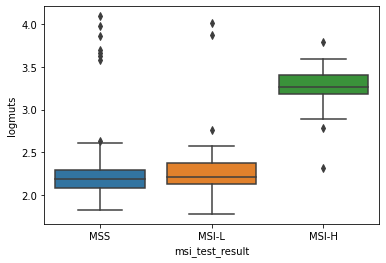

In [ ]:
import seaborn as sns

ax = sns.boxplot(x='msi_test_result', y='logmuts', data=mut_msi)

To check if the difference shown between groups is statistically significant, a Mann-Whitney U test can be performed - this is a non-parametric version of two-sample t-test suitable for long-tail count data like mutation loads. 

The test will be performed on 3 pairs: `MSI-H` vs `MSI-L`, `MSI-L` vs `MSS`, `MSI-H` vs `MSS`, and and statistical significance is measured based on the p-value set to p < 0.05. The built-in function used is `mannwhitneyu`, found in `scipy.stats`

In [ ]:
#===========================================================================
# Perform Mann-Whitney U test between MSI-H vs MSI-L, MSI-L vs MSS, MSI-H vs
# MSS, and report in which comparisons you find P value < 0.05
# df.loc[df['column_name'] == some_value]

import scipy.stats
MSS = mut_msi.loc[mut_msi['msi_test_result'] == 'MSS']
MSS_load = MSS['Hugo_Symbol']
MSH = mut_msi.loc[mut_msi['msi_test_result'] == 'MSI-H']
MSH_load = MSH['Hugo_Symbol']
MSL = mut_msi.loc[mut_msi['msi_test_result'] == 'MSI-L']
MSL_load = MSL['Hugo_Symbol']
msh_vs_msl = scipy.stats.mannwhitneyu(MSH_load, MSL_load)
msl_vs_mss = scipy.stats.mannwhitneyu(MSL_load, MSS_load)
msh_vs_mss = scipy.stats.mannwhitneyu(MSH_load, MSS_load)

print(msh_vs_msl)
print(msl_vs_mss)
print(msh_vs_mss)
#===========================================================================

MannwhitneyuResult(statistic=163.0, pvalue=2.231519308009102e-22)
MannwhitneyuResult(statistic=7820.5, pvalue=0.0304535109602922)
MannwhitneyuResult(statistic=539.5, pvalue=4.608445449243998e-34)


## Correlation between MSI condition and damaging mutations in MMR genes

One of the potential cause of MSI is the impaired [DNA mismatch repair (MMR) genes](https://en.wikipedia.org/wiki/DNA_mismatch_repair). Here, investigation will be done to observe a possible a correlation between functional impacting somatic mutations in MMR genes and the MSI condition.

This will be done using the MAF geneset file to identify which patients have at least one mutation with MODERATE / HIGH impact in the [15 genes involved in MMR](https://www.gsea-msigdb.org/gsea/msigdb/cards/REACTOME_MISMATCH_REPAIR.html) in human genome. 

In [ ]:
#=============================================================================
# Identify the patients who have at least one MODERATE or HIGH impact mutation
# in the 15 MMR genes in the mmr_geneset.txt file

mmr = ["EXO1",
"LIG1",
"MLH1",
"MSH2",
"MSH3",
"MSH6",
"PCNA",
"PMS2",
"POLD1",
"POLD2",
"POLD3",
"POLD4",
"RPA1",
"RPA2",
"RPA3"]
#=============================================================================

In [ ]:
filt_maf = maf[(maf.FILTER == "PASS") & ((maf.IMPACT == "MODERATE") | (maf.IMPACT == "HIGH"))]

print("{} out of {} mutations passed the filtering criteria, {:.2f}%".format(
    len(filt_maf), len(maf), 100 * len(filt_maf) / len(maf)))

156782 out of 264786 mutations passed the filtering criteria, 59.21%


In [ ]:
mutation_frequency = filt_maf.groupby("Hugo_Symbol")["bcr_patient_barcode"].nunique().reset_index()

mf_mmr_samples = filt_maf.loc[filt_maf.Hugo_Symbol.isin(mmr)].Tumor_Sample_Barcode.unique()

mf_mmr_samples.shape

(75,)

,Hugo_Symbol,Tumor_Sample_Barcode
0,A1BG,7
1,A1CF,8
2,A2M,20
3,A2ML1,34
4,A3GALT2,6
...,...,...
17942,ZYG11B,11
17943,ZYX,4
17944,ZZEF1,24
17945,ZZZ3,11


In [ ]:
filt_maf2 = maf[((maf.IMPACT == "MODERATE") | (maf.IMPACT == "HIGH"))]

print("{} out of {} mutations passed the filtering criteria, {:.2f}%".format(
    len(filt_maf2), len(maf), 100 * len(filt_maf2) / len(maf)))

167303 out of 264786 mutations passed the filtering criteria, 63.18%


In [ ]:
mutation_frequency2 = filt_maf2.groupby("Hugo_Symbol")["bcr_patient_barcode"].nunique().reset_index()

mf_mmr_samples2 = filt_maf2.loc[filt_maf2.Hugo_Symbol.isin(mmr)].bcr_patient_barcode.unique()
print(mf_mmr_samples2.shape)

filt_maf2 = filt_maf2[filt_maf2['bcr_patient_barcode'].isin(mf_mmr_samples2)]
fil_maf2_grouped = filt_maf2.groupby('bcr_patient_barcode').count()
fil_maf2_grouped.shape #confirm that there are 77 unique patients

(77,)


(77, 120)

### Answer the following questions

Evaluating association between mutations in MMR genes and MSI condition. The process will consist of:


1.   Creating a COUNT table (containing MSI groups and normal/mutation annotation, each entry a patient count).
2.   Performing a chi-square test to calculate significance of any association.



In [ ]:
#============================================================================
# Create a count table containing patient count in each pair of MSI condition
# vs MMR mutation status

# I believe it will look like:
#            MMR mut     MMR norm
#   MSI-H       50       71    
#   MSI-L       8        72    
#   MSS         19       254 

# Find the MMR mutated and ignoring the PASS filter (thus 77 total)
filt_msi_mmr = maf[((maf.IMPACT == "MODERATE") | (maf.IMPACT == "HIGH"))]
mf_mmr_samples2 = filt_msi_mmr.loc[filt_msi_mmr.Hugo_Symbol.isin(mmr)].bcr_patient_barcode.unique()
fmm_filt = filt_msi_mmr[filt_msi_mmr["bcr_patient_barcode"].isin(mf_mmr_samples2)]
fil_msimmr_grouped = fmm_filt.groupby('bcr_patient_barcode', as_index=False).count()
filt_maf_msi = fil_msimmr_grouped.merge(msi, on="bcr_patient_barcode")
fmm_msi_group = filt_maf_msi.groupby("msi_test_result").count()



# # Find the MMR normals, ignoring indeterminates and the PASS filter
filt_maf_norm = maf[((maf.IMPACT != "MODERATE") | (maf.IMPACT != "HIGH"))]
print(filt_maf_norm.shape)
fil_msimmr_notIn = filt_maf_norm.groupby('bcr_patient_barcode', as_index=False).count()
print(fil_msimmr_notIn.shape)
filt_norm_msi = fil_msimmr_notIn.merge(msi, on="bcr_patient_barcode")
fmN_grouped_norm = filt_norm_msi.groupby("msi_test_result").count()


obs = np.array([[50, 71], [8, 72], [19, 254]])

scipy.stats.chi2_contingency(obs)
#============================================================================

(264786, 121)
(399, 121)


(75.51964240470778,
 3.991333471871853e-17,
 2,
 array([[ 19.65611814, 101.34388186],
        [ 12.99578059,  67.00421941],
        [ 44.34810127, 228.65189873]]))